In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import gc
import zipfile
import requests
from PIL import Image
import io

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical

# Check GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.18.0


In [ ]:
# Memory optimization
def optimize_memory():
    """Optimize memory usage for Colab"""
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

optimize_memory()

In [ ]:
# Configuration
CONFIG = {
    'IMG_SIZE': 128,
    'BATCH_SIZE': 16,
    'EPOCHS': 20,
    'LEARNING_RATE': 0.001,
    'VALIDATION_SPLIT': 0.2,
    'PATIENCE': 3,
    'NUM_CLASSES': 2,
    'SEED': 42
}

np.random.seed(CONFIG['SEED'])
tf.random.set_seed(CONFIG['SEED'])

# Mount Google Drive
from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess a single image with memory optimization"""
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0
        return img
    except:
        return None

In [ ]:
class MemoryEfficientDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, shuffle=True, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

        # Data augmentation
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=30,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                brightness_range=[0.8, 1.2],
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            try:
                img = Image.open(self.image_paths[i]).convert('RGB')
                img = img.resize(self.img_size)
                img = np.array(img) / 255.0

                if self.augment and self.labels[i] == 1:  # Augment leaves more
                    img = self.datagen.random_transform(img)

                batch_images.append(img)
                batch_labels.append(self.labels[i])
            except:
                continue

        return np.array(batch_images), np.array(batch_labels) # Removed to_categorical

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# Function to create negative samples automatically from CIFAR-10
# NOTE: You DON'T need to provide negative samples - this function generates them automatically!
def create_negative_samples(num_samples=5000):
    """
    Automatically creates negative (non-leaf) samples from CIFAR-10 dataset.
    These are images of objects, animals, vehicles, etc. - clearly not leaves.
    CIFAR-10 includes some green/nature scenes (frogs, deer, birds) which helps
    the model distinguish leaves from other green objects.
    
    Args:
        num_samples: Number of negative samples to generate (default: 5000)
    
    Returns:
        List of file paths to negative sample images
    """
    print(f"Creating {num_samples} negative samples from CIFAR-10...")

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    negative_images_array = x_train[:num_samples]

    # Save negative samples to a temporary directory
    temp_neg_dir = "/tmp/negative_samples"
    os.makedirs(temp_neg_dir, exist_ok=True)
    negative_files = []
    print(f"Saving {num_samples} negative samples to {temp_neg_dir}...")
    for i, img_array in enumerate(negative_images_array):
        try:
            # Convert NumPy array to PIL Image
            img = Image.fromarray(np.uint8(img_array))
            file_path = os.path.join(temp_neg_dir, f"negative_{i}.png")
            img.save(file_path)
            negative_files.append(file_path)
        except Exception as e:
            print(f"Error saving negative image {i}: {e}")
            continue

    print(f"Saved {len(negative_files)} negative samples")
    return negative_files

In [ ]:
# Function to prepare dataset
def prepare_dataset(leaf_data_path, num_negative_samples=5000):
    """
    Prepare the dataset with leaf images and automatically generated negative samples.
    
    Args:
        leaf_data_path: Path to directory containing leaf images (all crop folders)
        num_negative_samples: Number of negative samples to generate (default: 5000)
                            Includes green images that are not leaves (helps robustness)
    
    NOTE: You only need to provide leaf images! Negative samples are generated automatically.
    """
    
    # Load all leaf images from all crop folders
    print("Loading leaf images from all crops...")
    leaf_files = []
    for root, dirs, files in os.walk(leaf_data_path):
        # Collect all images from all subdirectories (maize/, tomato/, potato/, etc.)
        for file in files:
            if file.lower().endswith(('.png', '.jpg', ".JPG", '.jpeg')):
                leaf_files.append(os.path.join(root, file))

    print(f"Found {len(leaf_files)} leaf images")

    # Create labels (1 = leaf, 0 = not leaf)
    leaf_labels = [1] * len(leaf_files)

    # Automatically create negative samples from CIFAR-10 (non-leaf images)
    # Includes green/nature scenes (frogs, deer, birds) to help distinguish from leaves
    # You don't need to provide these - they're generated automatically!
    negative_files = create_negative_samples(num_samples=num_negative_samples)

    negative_labels = [0] * len(negative_files)

    # Combine paths and labels
    all_paths = leaf_files + negative_files
    all_labels = leaf_labels + negative_labels

    return all_paths, all_labels

In [ ]:
# Build the model
def create_model():
    """Create EfficientNet-B0 based binary classifier"""

    # Load pre-trained EfficientNet-B0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], 3)
    )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
# Training function
def train_model(model, train_generator, val_generator):
    """Train the model with callbacks"""

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
        loss='binary_crossentropy', # Changed to binary_crossentropy
        metrics=['accuracy']
    )

    # Callbacks
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=CONFIG['PATIENCE'],
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            'best_leaf_classifier.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train
    history = model.fit(
        train_generator,
        epochs=CONFIG['EPOCHS'],
        validation_data=val_generator,
        callbacks=callbacks_list,
        verbose=1
    )

    return history

In [ ]:
# Fine-tuning function
def fine_tune_model(model, train_generator, val_generator):
    """Fine-tune the model with unfrozen layers"""

    # Unfreeze some layers
    model.layers[0].trainable = True

    # Compile with lower learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']/10),
        loss='binary_crossentropy',  # Fixed: changed from categorical_crossentropy
        metrics=['accuracy']
    )

    # Fine-tune for few epochs
    history_fine = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator,
        verbose=1
    )

    return history_fine

In [ ]:
# Evaluation function
def evaluate_model(model, test_generator):
    """Evaluate model performance"""

    # Predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # True labels (you'll need to extract these from your test generator)
    y_true = []
    for i in range(len(test_generator)):
        _, labels = test_generator[i]
        y_true.extend(labels) # Labels are already in the correct format

    y_true = np.array(y_true[:len(y_pred_classes)])

    # Metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=['Not Leaf', 'Leaf']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Leaf', 'Leaf'],
                yticklabels=['Not Leaf', 'Leaf'])
    plt.title('Confusion Matrix - Leaf vs Not Leaf')
    plt.show()

    # ROC curve
    y_pred_proba = y_pred.flatten() if y_pred.ndim > 1 else y_pred  # Probability of the positive class (leaf)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    return y_pred, y_pred_classes, auc_score


In [ ]:
# Main execution
def main():
    """Main training pipeline"""

    # Path to your leaf data directory (contains all crop folders with leaf images)
    LEAF_DATA_PATH = "/content/drive/MyDrive/smartcrop-ai/data/raw/train"  # Or path to your data/raw directory
    LOCAL_LEAF_PATH = "/content/local_leaf_data"

    copy_dataset_to_local(LEAF_DATA_PATH, LOCAL_LEAF_PATH)

    print("Preparing dataset...")
    all_paths, all_labels = prepare_dataset(LOCAL_LEAF_PATH)

    # Split data
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        all_paths, all_labels, test_size=0.2, random_state=CONFIG['SEED'], stratify=all_labels
    )

    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=0.2, random_state=CONFIG['SEED'], stratify=train_labels
    )

    # Create data generators
    train_generator = MemoryEfficientDataGenerator(
        train_paths, train_labels, CONFIG['BATCH_SIZE'],
        (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), shuffle=True, augment=True
    )

    val_generator = MemoryEfficientDataGenerator(
        val_paths, val_labels, CONFIG['BATCH_SIZE'],
        (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), shuffle=False, augment=False
    )

    test_generator = MemoryEfficientDataGenerator(
        test_paths, test_labels, CONFIG['BATCH_SIZE'],
        (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), shuffle=False, augment=False
    )

    print("Creating model...")
    model = create_model()
    model.summary()

    print("Training model...")
    history = train_model(model, train_generator, val_generator)

    print("Fine-tuning model...")
    history_fine = fine_tune_model(model, train_generator, val_generator)

    print("Evaluating model...")
    y_pred, y_pred_classes, auc_score = evaluate_model(model, test_generator)

    model.save('final_leaf_classifier.h5')
    print("Model saved as 'final_leaf_classifier.h5'")

    del model, train_generator, val_generator, test_generator
    gc.collect()



In [ ]:

def predict_single_image(model_path, image_path):
    """Predict if an image contains a leaf or not"""

    model = tf.keras.models.load_model(model_path)

    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict (binary classification: 0 = not leaf, 1 = leaf)
    prediction = model.predict(img, verbose=0)
    probability = float(prediction[0][0])  # Probability of being a leaf (sigmoid output)

    if probability > 0.5:
        result = "Leaf"
    else:
        result = "Not Leaf"

    return result, probability


Copying dataset from /content/drive/MyDrive/PlantVillage to /content/local_plantvillage...
Destination directory already exists. Skipping copy.
Preparing dataset...
Loading tomato leaf images...
Found 16011 tomato leaf images
Creating negative samples from CIFAR-10...
Saving 16000 negative samples to /tmp/negative_samples...
Saved 16000 negative samples
Creating model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,300 (16.10 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 4,052,387 (15.46 MB)

Training model...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1280/1281 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6319 - loss: 0.6891

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.49961, saving model to best_tomato_classifier.h5


1281/1281 ━━━━━━━━━━━━━━━━━━━━ 145s 92ms/step - accuracy: 0.6320 - loss: 0.6890 - val_accuracy: 0.4996 - val_loss: 0.7377 - learning_rate: 0.0010
Epoch 2/20
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7624 - loss: 0.4871
Epoch 2: val_accuracy improved from 0.49961 to 0.49980, saving model to best_tomato_classifier.h5


1281/1281 ━━━━━━━━━━━━━━━━━━━━ 99s 77ms/step - accuracy: 0.7624 - loss: 0.4871 - val_accuracy: 0.4998 - val_loss: 0.8089 - learning_rate: 0.0010
Epoch 3/20
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7829 - loss: 0.4450
Epoch 3: val_accuracy did not improve from 0.49980
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 97s 76ms/step - accuracy: 0.7829 - loss: 0.4450 - val_accuracy: 0.4998 - val_loss: 0.7531 - learning_rate: 0.0010
Epoch 4/20
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7993 - loss: 0.4128
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 4: val_accuracy did not improve from 0.49980
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 142s 76ms/step - accuracy: 0.7993 - loss: 0.4128 - val_accuracy: 0.4998 - val_loss: 0.7417 - learning_rate: 0.0010
Epoch 5/20
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8144 - loss: 0.3911
Epoch 5: val_accuracy did not improve from 0.49980
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 97s 76ms/step - accuracy: 0.8144 - l

/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1281/1281 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9920 - loss: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1281/1281 ━━━━━━━━━━━━━━━━━━━━ 233s 121ms/step - accuracy: 0.9920 - loss: 0.0000e+00 - val_accuracy: 0.5002 - val_loss: 0.0000e+00
Epoch 2/5
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 111s 87ms/step - accuracy: 0.9990 - loss: 0.0000e+00 - val_accuracy: 0.4998 - val_loss: 0.0000e+00
Epoch 3/5
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 112s 87ms/step - accuracy: 0.9997 - loss: 0.0000e+00 - val_accuracy: 0.4998 - val_loss: 0.0000e+00
Epoch 4/5
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 110s 86ms/step - accuracy: 0.9986 - loss: 0.0000e+00 - val_accuracy: 0.4998 - val_loss: 0.0000e+00
Epoch 5/5
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 110s 86ms/step - accuracy: 0.9990 - loss: 0.0000e+00 - val_accuracy: 0.4998 - val_loss: 0.0000e+00
Evaluating model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


401/401 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step
Classification Report:
              precision    recall  f1-score   support

  Not Tomato       0.50      1.00      0.67      3200
      Tomato       0.00      0.00      0.00      3203

    accuracy                           0.50      6403
   macro avg       0.25      0.50      0.33      6403
weighted avg       0.25      0.50      0.33      6403



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


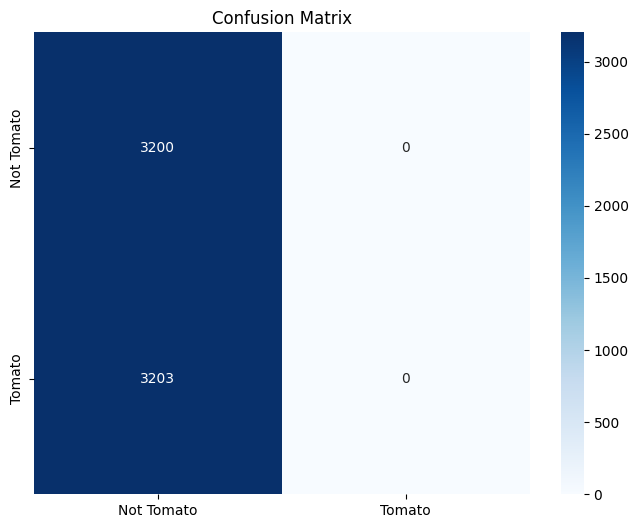

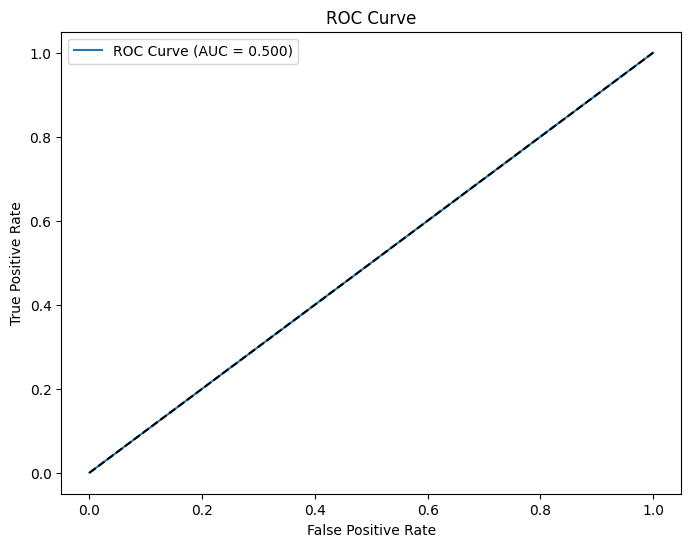

Model saved as 'final_tomato_classifier.h5'
Training completed!


In [ ]:
main()

In [ ]:
import shutil

# Function to copy dataset to local disk
def copy_dataset_to_local(source_path, destination_path):
    """Copies the dataset from source_path to destination_path."""
    print(f"Copying dataset from {source_path} to {destination_path}...")
    try:
        shutil.copytree(source_path, destination_path)
        print("Dataset copied successfully.")
    except FileExistsError:
        print("Destination directory already exists. Skipping copy.")
    except Exception as e:
        print(f"Error copying dataset: {e}")

# Define local dataset path
LOCAL_LEAF_PATH = "/content/local_leaf_data"